# Introduction to Deep Learning Training 1.2
## MNIST Deep dive

In this notebook we will deep dive on how a CNN works using a classical dataset in DL: MNIST (remember the handwritten digit classifier from Yann LeCun in 1998: [LeNet 5](http://yann.lecun.com/exdb/lenet/))?

Sidenote: **You won't need any GPU for this notebook, you can keep just a CPU it will be fine ;)**

### About The Data

In this lesson, we will be working with ***MNIST***, a classic data set of hand-written digits.  Solutions to this problem are for instance used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

A image can be represented by a matrix, by creating a grid where each entry corresponds to a different pixel.

<img src="https://s15.postimg.cc/9c81y146z/digit.gif" alt="digit" style="width: 55%"/>
  
(Source of image: [Adam Geitgey](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721) )

In this case we are using black & white images, so you have enough with one number per pixel to specify the color. However if you are working with color images, the principle is the same, except that you have 3 numbers per pixel: RGB = Red Green Blue => 3 input channels, but it works in the same way.

## Imports and data

We will be using the fastai library, in which we can find the data as well.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [5]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

You can see they are nearly the same, but the big difference is that a PyTorch tensor can be speed up on a GPU

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

## Stochastic Gradient Descent (SGD)

Do you remember the way that Arthur Samuel described machine learning, which we quoted in the intro?

> Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

We could look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w): return (x*w).sum()
```
Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated below, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

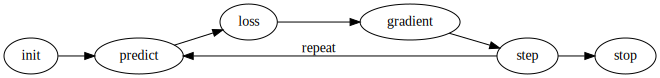

In [11]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this class. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

In [12]:
def f(x): 
    return x**2

/opt/conda/lib/python3.7/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


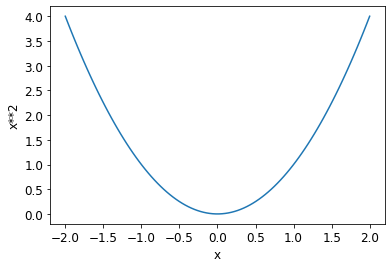

In [13]:
# Here is a graph of that function:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

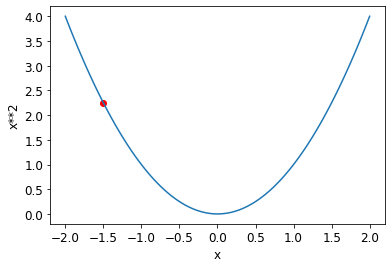

In [14]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

<img alt="A graph showing the squared function with the slope at one point" width="400" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/grad_illustration.svg"/>

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

<img alt="An illustration of gradient descent" width="400" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_perfect.svg"/>

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some handy ways we can make it faster, by finding better steps.

### Calculating Gradients
The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.

First, let's pick a tensor value which we want gradients at:

In [15]:
xt = tensor(3.).requires_grad_()

In [16]:
xt

tensor(3., requires_grad=True)

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

> This API might throw you off if you're coming from math or physics. In those contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of. It may feel backwards at first, but it's just a different perspective.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [17]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

In [18]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

We can now view the gradients by checking the `grad` attribute of our tensor:

In [19]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!


Now we'll repeat the preceding steps, but with a vector argument for our function:

In [20]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [21]:
def f(x): 
    return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are `2*xt`, as we'd expect!

In [22]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later, called the *learning rate finder*). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*. Notice how we _subtract_ the `gradient * lr` from the parameter to update it.  This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.  We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss.

If you pick a learning rate that's too low, it can mean having to do a lot of steps. The figure below illustrates that.

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_small.svg" id="descent_small"/>

But picking a learning rate that's too high is even worse—it can actually result in the loss getting *worse*, as we see below

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_div.svg" id="descent_div"/>

If the learning rate is too high, it may also "bounce" around, rather than actually diverging; The image below shows how this has the result of taking many steps to train successfully.

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_bouncy.svg" id="descent_bouncy"/>

Now let's apply all of this in an end-to-end example.

### An End-to-End SGD Example

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [23]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

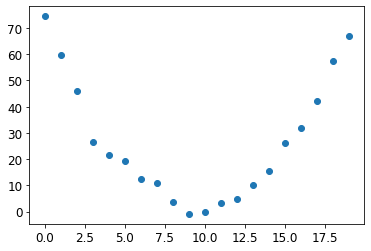

In [24]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

In [25]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. It is important for loss functions to return _lower_ values when predictions are more accurate, as the SGD procedure we defined earlier will try to _minimize_ this loss. For continuous data, it's common to use *mean squared error*:

In [26]:
def mse(preds, targets): 
    return ((preds-targets)**2).mean().sqrt()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [27]:
params = torch.randn(3).requires_grad_()

In [28]:
# saving the params to make a plot later, you can ignore this
orig_params = params.clone()

#### Step 2: Calculate the predictions
Next, we calculate the predictions:

In [29]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [30]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

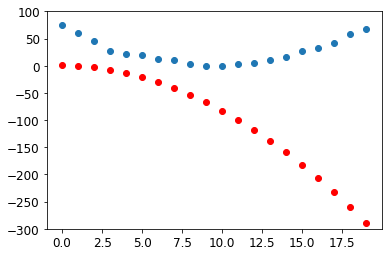

In [31]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss
We calculate the loss as follows:

In [32]:
loss = mse(preds, speed)
loss

tensor(160.6979, grad_fn=<SqrtBackward>)

Our goal is now to improve this. To do that, we'll need to know the gradients.
#### Step 4: Calculate the gradients
The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [33]:
loss.backward()
params.grad

tensor([-165.5151,  -10.6402,   -0.7900])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [34]:
params.grad * 1e-5

tensor([-1.6552e-03, -1.0640e-04, -7.8996e-06])

In [35]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights.

Now we need to update the parameters based on the gradients we just calculated:


In [36]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved:

In [37]:
preds = f(time,params)
mse(preds, speed)

tensor(160.4228, grad_fn=<SqrtBackward>)

And take a look at the plot:

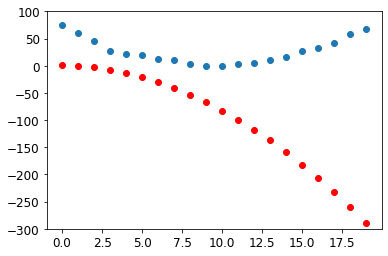

In [38]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [39]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [40]:
for i in range(10): apply_step(params)

160.42279052734375
160.14772033691406
159.87269592285156
159.59768676757812
159.3227081298828
159.04774475097656
158.7728271484375
158.4979248046875
158.22305297851562
157.9481964111328


In [41]:
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

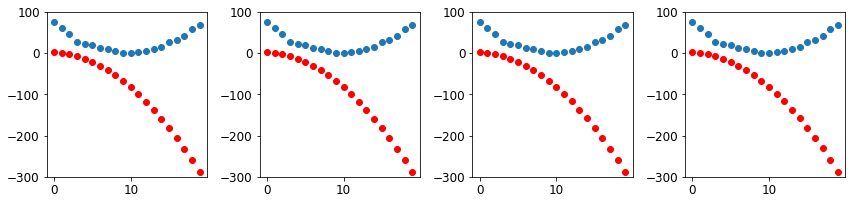

In [42]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()